<a href="https://colab.research.google.com/github/BrenoMilagres/DataScienceProjetos_Python_R/blob/master/Sistema_recomendacao_filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomendação aplicado ao ambiente da netflix
Para todos os negócios ligados a comércio eletrônico, é provável que os sistemas de recomendação sejam a ferramenta analítica mais importante já implementada. Embora não existam estimativas oficiais, muitas fontes estimam que, para as principais plataformas de comércio eletrônico, como a Amazon e a Netflix, os sistemas de recomendação podem ser responsáveis por até 10% a 35% da receita destas empresas. Esses são números consideráveis. Em um mundo com baixo crescimento, conseguir aumentar em 10% o seu faturamento, faz dos sistemas de recomendação algo que devemos olhar com mais atenção. Vamos compreender o que são esses sistemas.

Sistemas de Recomendação são, portanto, modelos preditivos que a partir de análise estatística, determinam a probabilidade de um cliente estar interessado por um outro item similar ao que está comprando em um dado momento.

Os tipos de sistemas de recomendaçãodependem de diferentes algoritmos.

- Alguns têm um foco maior nas semelhanças de clientes, alguns em similaridades de conteúdo e alguns uma mistura dos dois.

- Diferentes algoritmos variam em sua utilidade com base no quanto você sabe com antecedência sobre os clientes, seu conteúdo e se você pode obter feedback dos clientes após a compra (isso seria fundamental).

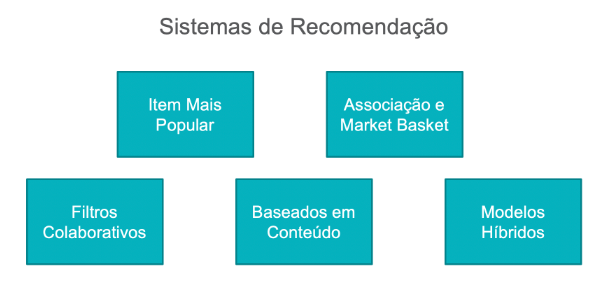


#### imports 

In [39]:
import pandas  as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy 
import sklearn
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from scipy.sparse import csr_matrix
from datetime import datetime

#### Dicionário de Dados
- MovieID
- CustumerID
- Notas: 1 a 5
- Data: YYYY-MM-DD

#### Tratativas  com arquivos carregados
- ler as linhas de todos os arquivos
- combinar todos os arquivos em um só
- carregar o arquivo consolidado em um dataframe 

In [40]:
# criando arquivo .csv para receber todos os dados

if not os.path.isfile ('dados/dados.csv'):

  dataset = open('dados/dados.csv' , mode='w')

  linhas = list()

  arquivos = ['dados/combined_data_1.txt' ,'dados/combined_data_2.txt','dados/combined_data_3.txt','dados/combined_data_4.txt']

  ### Percorre todos os arquivos da  lista de  arquivos
  for arquivo in arquivos:

    with open(arquivo) as f:
      ## lendo cada linha  do arquivo 
      for linha in f:
        del linhas[:]
        
        linha = linha.strip()
        

        ## se a linha terminar com dois pontos indica que é o ID do filme
        if linha.endswith(':'):
          move_id = linha.replace(':','')
        ## se não separamos as colunas por virgula e preenchemos a lista  de linhas
        else:

          linhas = [x for x in linha.split(',')]
          linhas.insert(0,move_id)
          ## escrevendo no arquivo
          dataset.write(','.join(linhas))
          dataset.write('\n')
  print('concluído')





In [41]:
## carregando dataframe 

df_netflix = pd.read_csv('dados/dados.csv' , sep=',', names=['movie','user','rating','date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866039 entries, 0 to 866038
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   movie   866039 non-null  int64         
 1   user    866039 non-null  int64         
 2   rating  866037 non-null  float64       
 3   date    866036 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 26.4 MB


#### Análise exploratória 

In [42]:
# Função para ajuste das unidades de medida
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


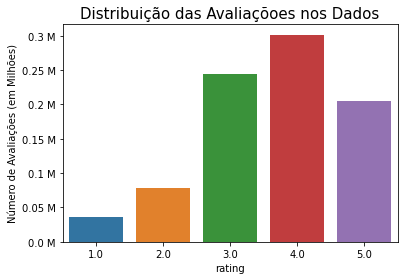

In [44]:
# Plot: Verificando distribuição das avaliações 
fig, ax = plt.subplots()
plt.title('Distribuição das Avaliaçõoes nos Dados', fontsize = 15)
sns.countplot(df_netflix.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Número de Avaliações (em Milhões)')
plt.show()

In [45]:
## VErificando se o dia d a  semana influencia nas classificações
# Extrai o dia da semana e grava em uma nova coluna
df_netflix['dia_semana'] = df_netflix['date'].dt.strftime("%A")
df_netflix.head()

,movie,user,rating,date,dia_semana
0,1,1488844,3.0,2005-09-06,Tuesday
1,1,822109,5.0,2005-05-13,Friday
2,1,885013,4.0,2005-10-19,Wednesday
3,1,30878,4.0,2005-12-26,Monday
4,1,823519,3.0,2004-05-03,Monday


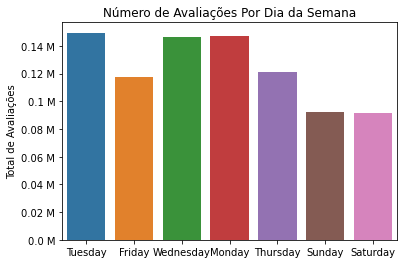

In [46]:
### Plot: classificações por dias da semana:
fig, ax = plt.subplots()
sns.countplot(x = 'dia_semana', data = df_netflix, ax = ax)
plt.title('Número de Avaliações Por Dia da Semana')
plt.ylabel('Total de Avaliações')
plt.xlabel('')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

In [47]:
# Média de avaliações por dia da semana
media_dia_semana = df_netflix.groupby(by = ['dia_semana'])['rating'].mean()
print("Média de Avaliações")
print("-"*30)
print(media_dia_semana)
print("\n")

Média de Avaliações
------------------------------
dia_semana
Friday       3.648813
Monday       3.644439
Saturday     3.658465
Sunday       3.656753
Thursday     3.643052
Tuesday      3.638679
Wednesday    3.643425
Name: rating, dtype: float64




O dia da semana parece não influenciar nas classificações uma vez que todos os dias possuem médias bem próximas.

In [16]:
## ordenando dataframe 
df_netflix.sort_values(by='date',inplace=True)
df_netflix.head()

,move,user,rating,date,dia_semana
410090,4570,2287590,5.0,1999-12-28,Tuesday
411323,4570,530721,3.0,1999-12-30,Thursday
154146,4503,471064,3.0,1999-12-31,Friday
599403,9235,1723352,4.0,1999-12-31,Friday
639773,9240,1611303,2.0,2000-01-05,Wednesday


In [17]:
df_netflix['rating'].describe()

count    866037.000000
mean          3.646467
std           1.064215
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [18]:
df_netflix.isnull().sum()

move          0
user          0
rating        2
date          3
dia_semana    3
dtype: int64

In [19]:
df_netflix.dropna(inplace=True)
df_netflix.drop_duplicates(inplace=True)
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866036 entries, 410090 to 291253
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   move        866036 non-null  int64         
 1   user        866036 non-null  int64         
 2   rating      866036 non-null  float64       
 3   date        866036 non-null  datetime64[ns]
 4   dia_semana  866036 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 39.6+ MB


#### Criando matriz esparsa 

In [20]:
matriz_esparsa = sparse.csr_matrix((df_netflix.rating.values,(df_netflix.user.values,df_netflix.move.values)))
matriz_esparsa.shape

### salvando em disco 
sparse.save_npz('dados/matriz_esparsa.npz',matriz_esparsa)

#### Calculando Matriz de  similaridade dos usuários.

In [21]:
# Função de cálculo de similaridade
def calcula_similaridade_usuario(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    # Variáveis de controle
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculando top", top, "similaridades para cada usuário...")
    start = datetime.now()
    temp = 0
    
    # Loop pela matriz
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculando a similaridade de cosseno
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Cálculo concluído para {} usuários [  tempo total : {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Criação de matriz esparsa a partir das semelhanças computadas...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Tempo de cálculo de cada usuário')
        plt.plot(np.cumsum(time_taken), label = 'Tempo Total')
        plt.legend(loc = 'best')
        plt.xlabel('Usuário')
        plt.ylabel('Tempo (segundos)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken  

Calculando top 100 similaridades para cada usuário...
Cálculo concluído para 20 usuários [  tempo total : 0:00:03.429515  ]
Cálculo concluído para 40 usuários [  tempo total : 0:00:06.725798  ]
Cálculo concluído para 60 usuários [  tempo total : 0:00:10.031018  ]
Cálculo concluído para 80 usuários [  tempo total : 0:00:13.324793  ]
Cálculo concluído para 100 usuários [  tempo total : 0:00:16.527947  ]
Criação de matriz esparsa a partir das semelhanças computadas...


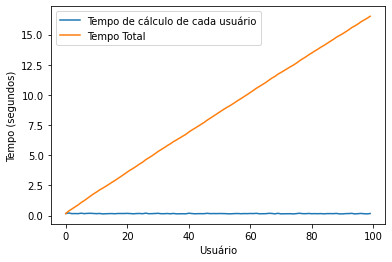

Tempo Total de Processamento: 0:00:16.946268


In [22]:
# Calculamos a similaridade

# Marca o início
start = datetime.now()

# Calcula a similaridade
matriz_esparsa_user, _ = calcula_similaridade_usuario(matriz_esparsa, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print("Tempo Total de Processamento:", datetime.now() - start)

#### Calculando matriz de similaridade dos filmes

In [23]:
# Cálculo da similaridade de filmes

# Marca o início
start = datetime.now()

# Cria se não existir
if not os.path.isfile('dados/matriz_esparsa_filme.npz'):
    matriz_esparsa_filme = cosine_similarity(X = matriz_esparsa.T, dense_output = False)
    print("Matriz Criada.")
    sparse.save_npz("dados/matriz_esparsa_filme.npz", matriz_esparsa_filme)
    print("Matriz Salva em Disco.")
else:
    matriz_esparsa_filme = sparse.load_npz("dados/matriz_esparsa_filme.npz")
    print("Matriz Carregada.")

print("Tempo de Processamento:", datetime.now() - start)

Matriz Criada.
Matriz Salva em Disco.
Tempo de Processamento: 0:00:00.301786


In [24]:
# Shape
matriz_esparsa_filme.shape

(13392, 13392)

In [25]:
# Extra os ids dos filmes
movie_ids = np.unique(matriz_esparsa_filme.nonzero()[1])

In [26]:
# Calcula a similaridade de filmes de acordo com o padrão de avaliação dos usuários

# Marca o início
start = datetime.now()

# Dicionário para armazenar as similaridades
filmes_similares = dict()

# Loop pelos ids dos filmes
for movie in movie_ids:
    # Obtemos os top filmes semelhantes e armazenamos no dicionário
    filmes_sim = matriz_esparsa_filme[movie].toarray().ravel().argsort()[::-1][1:]
    filmes_similares[movie] = filmes_sim[:100]
    
print("Tempo de Processamento:", datetime.now() - start)

Tempo de Processamento: 0:00:00.077581


In [31]:
# Filmes similares ao filme de id 7
filmes_similares[7]

array([ 4530,  4532,  4538,  9253,  9248,  4537, 13372,  4574,  4540,
        9233,  4571,  9227,  9245,  4510,  4556,  4550,  9249,  9215,
          16,  4504,  4502,  4558,  9225,  4539,  9239,  4544,  4511,
          20, 13376,  4554,     1,  4572,  4548,  4573,  4512,     2,
        4560,  9244,    29,    19,  9220, 13370,  4526,  4517,  9216,
        9213,  4500,     9,    24,  9223,    12,    21, 13387,  4566,
        9230, 13369,    27,  4552,  9211,  4541,  4528,     5,     4,
        9246,  4519,    10, 13375,    22,  9226,  4523,  4514,  4527,
        4518,  4534,  4569,  9237,  4561,  9212,  4547, 13385,  9222,
        4536, 13380,  9219,  9214,  4564,  4501,  4529,  4563,    15,
        4525,  4515,    26,  9238,    23, 13373,  4553,    25,  9221,
        4568])

#### Verificando quais os títulos dos filmes similares através do carregamento do csv disponibilizado pela netflix

In [32]:
# Vamos carregar os títulos dos filmes do arquivo csv fornecido pela Netflix
titulos_filmes = pd.read_csv("dados/movie_titles.csv", 
                             sep = ',', 
                             header = None,
                             names = ['ID_Filme', 'Ano_Lancamento', 'Titulo'], 
                             verbose = True,
                             index_col = 'ID_Filme', 
                             encoding = "ISO-8859-1")

Tokenization took: 9.60 ms
Type conversion took: 8.81 ms
Parser memory cleanup took: 0.01 ms


In [33]:
# Visualiza os dados
titulos_filmes.head()

,Ano_Lancamento,Titulo
ID_Filme,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


Verificando quais títulos são similares ao filme de id 7

In [35]:
# ID do filme
id_filme = 7
# Print
print("Filme:", titulos_filmes.loc[id_filme].values[1])
print("Total de Avaliações de Usuários = {}.".format(matriz_esparsa[:,id_filme].getnnz()))
print("Encontramos {} filmes que são similares a este e vamos imprimir os mais similares.".format(matriz_esparsa_filme[:,id_filme].getnnz()))

Filme: 8 Man
Total de Avaliações de Usuários = 93.
Encontramos 176 filmes que são similares a este e vamos imprimir os mais similares.


In [36]:
# Encontrando todas as similaridades
similarities = matriz_esparsa_filme[id_filme].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] 

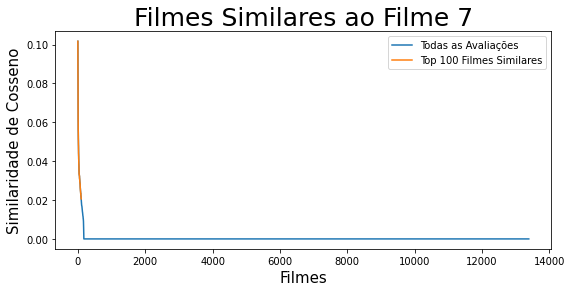

In [37]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similarities[sim_indices], label = 'Todas as Avaliações')
plt.plot(similarities[sim_indices[:100]], label = 'Top 100 Filmes Similares')
plt.title("Filmes Similares ao Filme {}".format(id_filme), fontsize = 25)
plt.xlabel("Filmes", fontsize = 15)
plt.ylabel("Similaridade de Cosseno", fontsize = 15)
plt.legend()
plt.show()

In [38]:
# Aqui os top 10 filmes mais similares ao filme 43
titulos_filmes.loc[sim_indices[:10]]

,Ano_Lancamento,Titulo
ID_Filme,,
4530,1985.0,Def Con 4
4532,1994.0,Shaolin Avengers
4538,1987.0,Ninja vs. Bruce Lee
9253,1921.0,Destiny
9248,1992.0,Grand Tour: Disaster in Time
4537,1997.0,Legend of the Wolf
13372,2002.0,Code Hunter
4574,1977.0,Pippi on the Run
4540,1990.0,Aashiqui
